In [14]:
import pandas as pd
import tensorflow as tf
import classification_utils
import numpy as np

In [15]:
df = pd.read_csv("./dataset/users_df_dataset_cleaned_with_indicators.csv")
# TODO check if it is the latest dataset

In [16]:
df.columns.values.tolist()

['user_id',
 'name',
 'lang',
 'bot',
 'created_at',
 'statuses_count',
 'account_age_in_days',
 'number_of_tweets',
 'account_average_tweets_per_day',
 'avg_tweets_per_actual_day',
 'day_with_most_tweets',
 'max_number_of_tweet_in_a_day',
 'entropy_for_day',
 'entropy_for_hour',
 'entropy_for_minute',
 'avg_hashtags',
 'avg_text_length',
 'avg_mentions',
 'avg_special_char_in_text',
 'total_likes',
 'avt_favorite_count',
 'total_replies',
 'avt_reply_count',
 'total_retweet_count',
 'account_discussion_creation_ratio',
 'tweet_num_likes_ratio',
 'tweet_num_replies_ratio']

In [17]:
to_drop = ["user_id", "name", "created_at", "day_with_most_tweets"]
to_discretize = ["lang"]

df.drop(to_drop, axis=1, inplace=True)
df = classification_utils.discretize_data(df, to_discretize)
df.drop(to_discretize, axis=1, inplace=True)
# TODO after the dataset update check again

In [18]:
df.head()

,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweet_in_a_day,entropy_for_day,entropy_for_hour,entropy_for_minute,...,avg_special_char_in_text,total_likes,avt_favorite_count,total_replies,avt_reply_count,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,lang_num
0,1,76,1314,126,0.057839,4.666667,18,2.903992,2.762944,1.867539,...,14.563492,5,0.039683,0,0.0,5,25.200000,25.200000,0.0,5
1,0,54,1311,116,0.041190,4.640000,17,2.942683,2.881816,1.909614,...,15.336207,6,0.051724,0,0.0,3,38.666667,19.333333,0.0,5
2,1,3,2709,4,0.001107,2.000000,3,1.000000,0.918296,0.918296,...,5.250000,0,0.000000,0,0.0,0,0.000000,0.000000,0.0,5
3,1,50,2080,1358,0.024038,8.035503,143,3.543607,1.320785,0.474758,...,19.241532,252,0.185567,0,0.0,1187,1.144061,5.388889,0.0,12
4,0,7085,1198,3434,5.914023,28.380165,50,4.253096,1.705484,0.510899,...,15.024461,213,0.062027,0,0.0,60,57.233333,16.122066,0.0,5


In [19]:
from sklearn.model_selection import train_test_split

label = df.pop("bot")

train_ratio = 0.70
validation_ratio = 0.20
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(df, label, stratify=label, shuffle=True, test_size= 1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_train, y_train, shuffle=True, test_size=test_ratio/(test_ratio + validation_ratio) )




In [20]:
x_train = np.asarray(x_train).astype("float32")
x_train = np.reshape(x_train, ( x_train.shape[0], 1, x_train.shape[1]))
x_val = np.asarray(x_val).astype("float32")
x_val = np.reshape(x_val, ( x_val.shape[0], 1, x_val.shape[1]))
x_test = np.asarray(x_test).astype("float32")
x_test = np.reshape(x_test, ( x_test.shape[0], 1, x_test.shape[1]))
y_train = np.asarray(y_train).astype("float32")
y_train = np.reshape(y_train, (-1, 1))
y_val = np.asarray(y_val).astype("float32")
y_val = np.reshape(y_val, (-1, 1))
y_test = np.asarray(y_test).astype("float32")
y_test = np.reshape(y_test, (-1, 1))

In [69]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(1, len(df.columns))),
  tf.keras.layers.Dense(128, activation='sigmoid'),  
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(128, activation='sigmoid'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

optizer = tf.keras.optimizers.experimental.SGD(
    learning_rate=0.02,
    momentum=0.002,
    weight_decay=0.00001,
    nesterov=True
)

model.compile(optimizer=optizer,
              loss='mean_squared_error',
              metrics=['accuracy'])


In [63]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 22)                0         
                                                                 
 dense_38 (Dense)            (None, 100)               2300      
                                                                 
 dense_39 (Dense)            (None, 100)               10100     
                                                                 
 dense_40 (Dense)            (None, 100)               10100     
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 22,601
Trainable params: 22,601
Non-trainable params: 0
_________________________________________________________________


In [70]:
history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=200,
                    verbose="auto",
                    validation_data=(x_val, y_val),
                    shuffle=True
                    )

Epoch 1/200
39/39 [==============================] - 1s 6ms/step - loss: 0.2501 - accuracy: 0.5505 - val_loss: 0.2475 - val_accuracy: 0.5502
Epoch 2/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2463 - accuracy: 0.5505 - val_loss: 0.2451 - val_accuracy: 0.5502
Epoch 3/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2437 - accuracy: 0.5505 - val_loss: 0.2425 - val_accuracy: 0.5502
Epoch 4/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2415 - accuracy: 0.5505 - val_loss: 0.2402 - val_accuracy: 0.5502
Epoch 5/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2390 - accuracy: 0.5505 - val_loss: 0.2378 - val_accuracy: 0.5502
Epoch 6/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2368 - accuracy: 0.5505 - val_loss: 0.2359 - val_accuracy: 0.5502
Epoch 7/200
39/39 [==============================] - 0s 4ms/step - loss: 0.2349 - accuracy: 0.5568 - val_loss: 0.2339 - val_accuracy: 0.5502
Epoch 8/200
3

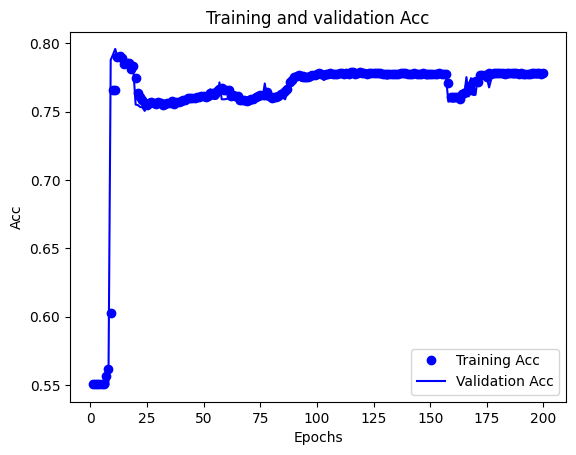

In [71]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [57]:
train_pred = (model.predict(x_train) > 0.5).astype("int32")
correct_train = 0
for (pred, expected) in zip(train_pred, y_train):
    if pred == expected:
        correct_train +=1

val_pred = (model.predict(x_val) > 0.5).astype("int32")
correct_val = 0
for (pred, expected) in zip(val_pred, y_val):
    if pred == expected:
        correct_val +=1

print("Training set:", correct_train , "correct over", len(x_train), "\nAccuracy in train:", correct_train/len(x_train))
print("Validation set:", correct_val , "correct over", len(x_val), "\nAccuracy in validation:", correct_val/len(x_val))


162/162 [==============================] - 0s 772us/step
Training set: 4281 correct over 7776 
Accuracy in train: 0.5505401234567902
Validation set: 2852 correct over 5184 
Accuracy in validation: 0.5501543209876543


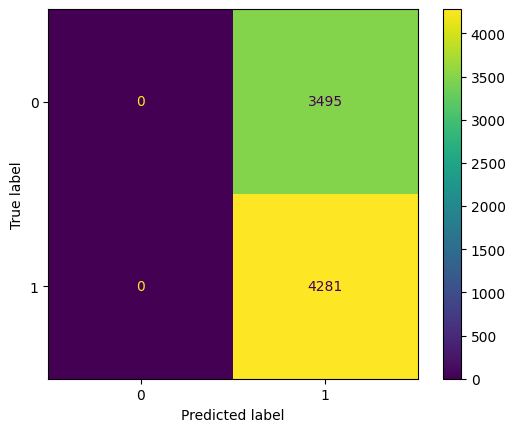

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()